In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

In [30]:
df = pd.read_csv('HousingData.csv')

In [31]:
# to view all columns of the database in the output window
pd.set_option('display.max_columns',None)

In [32]:
# seeing which all features have missing values
df.isna().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [33]:
# the columns with missing values are CRIM, ZN, INDUS, CHAS, AGE, and LSTAT, each with 20 missing values. The target variable MEDV does not have any missing values.

In [34]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [35]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [36]:
# Can we drop rows which have NaN values?
missing_row_count = df.isna().any(axis=1).sum() # Count of rows with at least one missing (NaN) value
print(missing_row_count)
#number of rows in the dataframe
len(df)

#since dropping 112 rows would make our dataset very small, we will impute missing values in the features

112


506

/var/folders/z0/f8x0px094r52y2v2fgmzyqmr0000gn/T/ipykernel_18778/1497194269.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(missing_features))  # Clean color palette


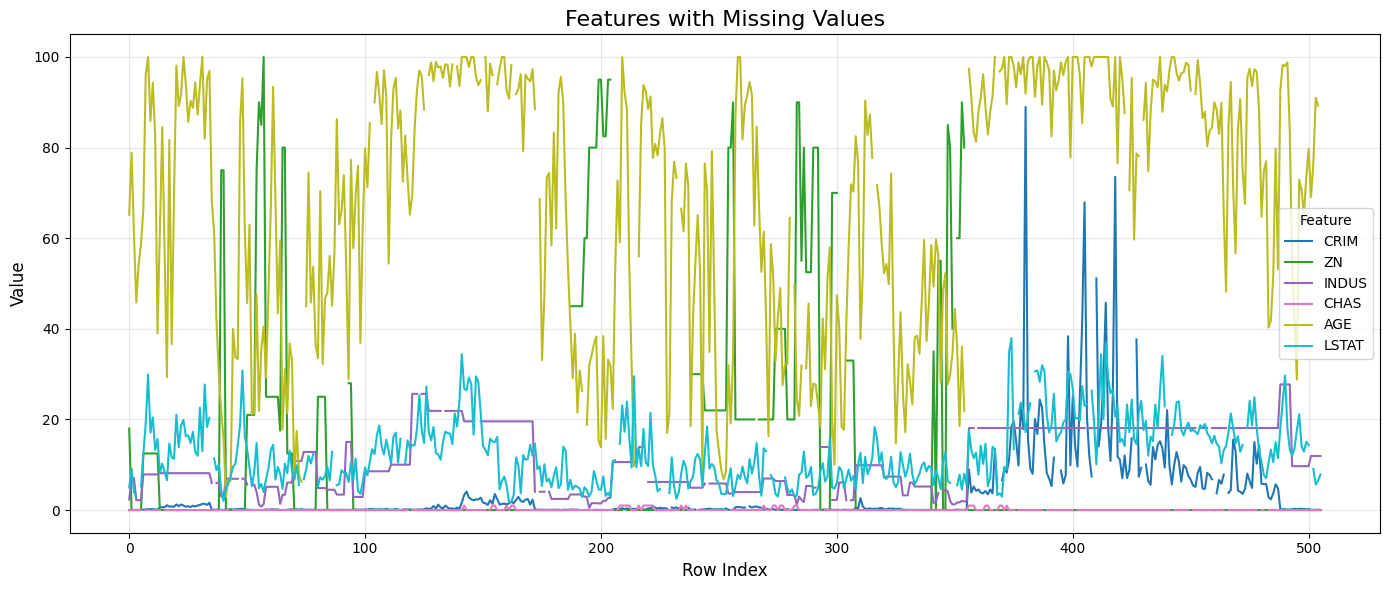

In [37]:
"""
Plotting all features with missing values on the y-axis against row index helps us:

- Visually inspect the **shape and structure** of each feature (e.g., smooth, noisy, or plateaued).
- Identify whether features exhibit **collinearity** or similar patterns — useful when deciding KNN-based imputation.
- Detect features that are **too erratic or zigzagged**, where local imputation (like KNN or interpolation) may be unreliable.
- Understand whether values change **gradually or abruptly** across the dataset, which can influence imputation strategy.

This kind of visualization provides intuition for selecting the most appropriate imputation method: 
mean/median for noisy distributions, KNN for locally structured features, and possibly dropping rows/features that are unstable or uninformative.
"""

"""
Should we normalise before plotting?
No
When you're visually inspecting each feature individually, you usually want to preserve their original scale and units, because that reflects the real-world meaning (e.g., AGE is in %, TAX is per $10k).
You don't want to flatten or distort shapes via scaling before assessing their structure.
For plots like your value vs. index, it's good to see actual values, not rescaled ones.
"""

# Features with missing values
missing_features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'AGE', 'LSTAT']
colors = cm.get_cmap('tab10', len(missing_features))  # Clean color palette

plt.figure(figsize=(14, 6))

for i, feature in enumerate(missing_features):
    plt.plot(df.index, df[feature], label=feature, color=colors(i), linewidth=1.5)

plt.title("Features with Missing Values", fontsize=16)
plt.xlabel("Row Index", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(title="Feature", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [38]:
"""
Exploring collinearity between AGE and LSTAT to assess whether one can be used to impute the other.
1. However, since both features contain missing values, using one to impute the other may introduce circular logic.
2. This is problematic because each depends on incomplete information, making such imputation unreliable without prior handling.

What can be done instead:
- Impute one with a simpler method first (e.g., median for AGE),
- Then use it to impute the other (e.g., LSTAT via regression or KNN),
- Or exclude rows where both are missing if that’s acceptable and rare.
"""
df[['AGE', 'LSTAT']].corr()

,AGE,LSTAT
AGE,1.000000,0.602891
LSTAT,0.602891,1.000000


In [39]:
# imputing CHAS
df['CHAS'].value_counts()
# since CHAS is a categorical feature which is heavily imbalanced towards 0, we can impute missing values with 0, as it reflects the mode. And avoids introducing rare class bias (imputing 1s by mistake).
chas_mode = df['CHAS'].mode()[0]
df['CHAS'].fillna(chas_mode, inplace=True)

In [40]:
"""
Zigzag / Noisy patterns

Features like AGE and ZN jump rapidly, without smooth local structure.
→ These are bad candidates for KNN or interpolation, because:

Nearby rows (in index) don't behave similarly.
No smoothness = KNN may pull in totally unrelated neighbors
"""

"\nZigzag / Noisy patterns\n\nFeatures like AGE and ZN jump rapidly, without smooth local structure.\n→ These are bad candidates for KNN or interpolation, because:\n\nNearby rows (in index) don't behave similarly.\nNo smoothness = KNN may pull in totally unrelated neighbors\n"

Mean AGE: 68.51851851851852
Median AGE: 76.80000000000001


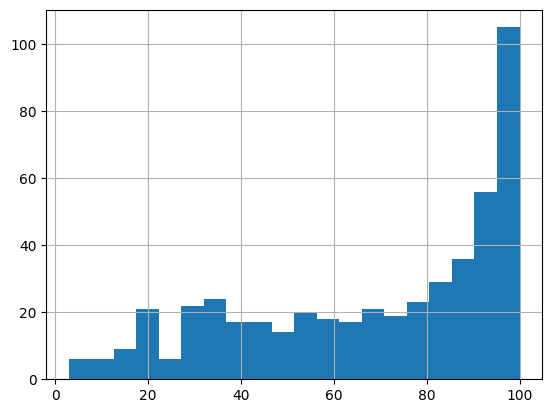

In [41]:
# imputing for AGE 
print("Mean AGE:", df['AGE'].mean())
print("Median AGE:", df['AGE'].median())
df['AGE'].hist(bins=20)
#since the histogram is so right-skewed, the mean would be quite skewed, so, we will use median to impute missing age values.
df['AGE'].fillna(df['AGE'].median(), inplace=True)

Mean ZN: 11.2119341563786
Median ZN: 0.0


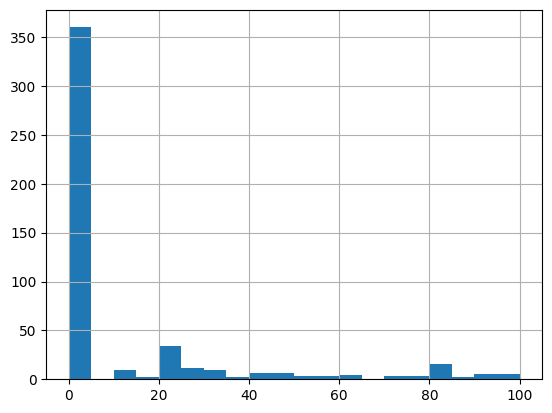

In [42]:
# imputing for ZN
print("Mean ZN:", df['ZN'].mean())
print("Median ZN:", df['ZN'].median())
df['ZN'].hist(bins=20)
# most zn values are 0, so we can impute with the median 0. non zero values are sparse and scattered
df['ZN'].fillna(df['ZN'].median(), inplace=True)

Mean LSTAT: 12.715432098765433
Median LSTAT: 11.43


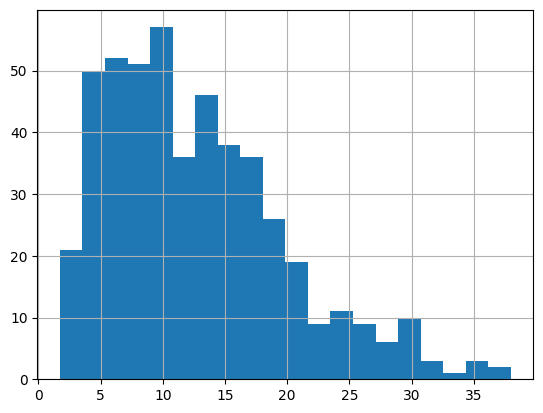

In [43]:
"""imputing LSTAT
While LSTAT (percentage of lower-status population) is less erratic than AGE or ZN, it's still:
Right-skewed (long tail on the high end),
Not smoothly varying enough to trust interpolation,
And lacks strong, consistent correlation with other features (as shown in your scatter plots).
"""
print("Mean LSTAT:", df['LSTAT'].mean())
print("Median LSTAT:", df['LSTAT'].median())
df['LSTAT'].hist(bins=20)
df['LSTAT'].fillna(df['LSTAT'].median(), inplace=True)

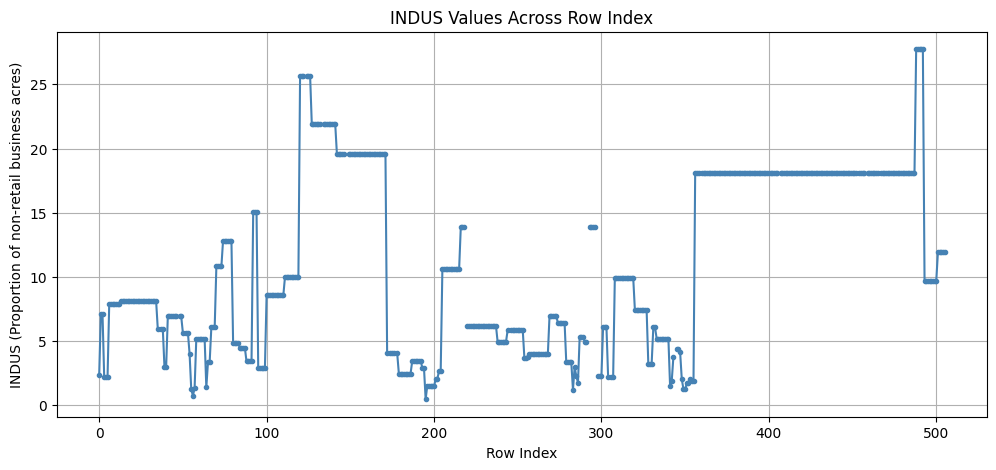

In [44]:
# imputing for INDUS
# first we plot INDUS values against row index to see if any pattern stands out
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['INDUS'], linestyle='-', marker='o', markersize=3, color='steelblue')
plt.title("INDUS Values Across Row Index")
plt.xlabel("Row Index")
plt.ylabel("INDUS (Proportion of non-retail business acres)")
plt.grid(True)
plt.show()

In [45]:
# ---------------------------------------
# IMPUTATION STRATEGY FOR 'INDUS' FEATURE
# ---------------------------------------

# When we plotted INDUS against row index, we observed long plateaus — e.g., stretches where 
# many rows had the same INDUS value like 18.1 or 19.58, followed by sudden changes. 
# This gave us the intuition that these plateaus might not be random — maybe they’re the result 
# of natural groupings in the data (like similar towns or zones), and those groupings might also 
# be reflected in other features like TAX, NOX, AGE, or DIS.

# That led us to consider using KNN or clustering for imputation:
# If rows with similar INDUS values also tend to have similar values in other features,
# then we could find "neighborhoods" in feature space and use them to impute missing INDUS values.

# However, this is just a visual hypothesis based on the index — which may have no geographic or 
# neighborhood meaning. The plateaus might be real, or INDUS could be largely independent. 
# We cannot assume KNN or clustering will work unless we test this properly.

# To justify KNN:
# - We would first check individual correlations:
#     df.corr()['INDUS'].sort_values(ascending=False)
#   and select features with moderate correlation (|r| > 0.3).
# - Even if no individual feature is highly correlated, combinations of features (e.g., TAX + NOX + AGE)
#   might form meaningful neighborhoods — which KNN could use.
# - To explore this, we would need dimensionality reduction tools like PCA, t-SNE, or UMAP to check 
#   if similar INDUS values cluster in reduced feature space.
# - We could also validate clustering structure using silhouette scores or visual inspection.

# Practical limitations with KNN or clustering:
# - We must exclude the target variable MEDV to prevent data leakage during imputation.
# - We must also exclude CRIM since it has missing values — KNN requires all features to be non-null.
# - Not all features are guaranteed to help predict INDUS — including irrelevant ones may add noise.
# - Scaling is required since KNN is distance-based.
# - Both KNN and clustering require tuning, validation, and extra computation.

# Clustering (e.g., KMeans) is another option — group similar rows and impute INDUS with the group’s mean —
# but it comes with the same overhead: handling missing values, feature selection, preprocessing, and validation.

# Given all this effort — and the fact that INDUS has only 20 missing values — we choose a simple, safe
# approach for now:
#     - Use **mode** (most frequent value) for imputation — since INDUS has dominant repeated values.
#     - Alternatively, use **median** if distribution appears continuous but skewed.

# Later, once the model is trained, we can use SHAP values or other interpretability tools to evaluate 
# how important INDUS actually was. If it turns out to be significant, we can revisit its imputation 
# and apply a more rigorous method like KNN or clustering-based approaches.

# FINAL IMPUTATION (for now):
df['INDUS'].fillna(df['INDUS'].mode()[0], inplace=True)

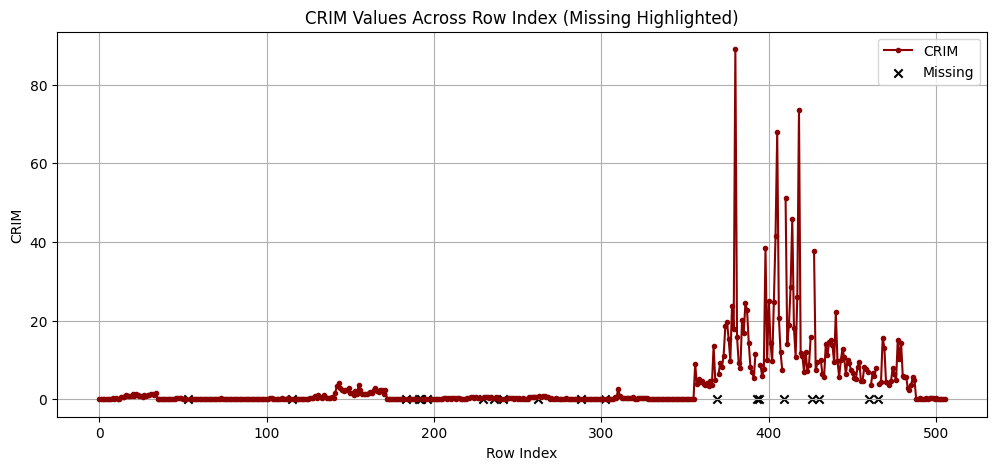

In [46]:
# Imputing CRIM
# Overlay missing points in red Xs on plot of CRIM values against row indices.
missing_indices = df[df['CRIM'].isna()].index
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['CRIM'], linestyle='-', marker='o', markersize=3, color='darkred', label='CRIM')
plt.scatter(missing_indices, [0]*len(missing_indices), color='black', marker='x', label='Missing')
plt.title("CRIM Values Across Row Index (Missing Highlighted)")
plt.xlabel("Row Index")
plt.ylabel("CRIM")
plt.grid(True)
plt.legend()
plt.show()

In [47]:
"""
CRIM is mostly very low, clustered near 0, for the majority of rows.
Around row 360–460, there’s a sharp rise with many spikes up to 80–90.
The missing values are scattered throughout, including in both the low-CRIM and high-CRIM zones.
So there are clearly two major regimes:
- Low-crime zones (dense, flat region near 0)
- High-crime zones (spiky cluster later in index)

Possible Approachs:
1.  Clustering-Based Imputation
    Cluster rows into 2–3 groups using all complete features, and impute CRIM using the average (or median) of the cluster the row belongs to.
    Why it makes sense:
    The plot clearly suggests CRIM behaves in clusters.
    If neighborhoods with high TAX/NOX/AGE correspond to high CRIM, clustering will capture that.
2.  Classification-Based Imputation
    Treat imputation as a supervised task: train a model to predict CRIM range (e.g., low vs high crime), and use that to infer missing values.
    Feels overkill, especially for only 20 missing values — and not ideal unless you're imputing categories, not continuous values.
3.  Index-Based Averaging (Local Neighborhoods)
    Use a simple moving window (±2 or ±3 rows) to take the average of nearby non-null values.
    This is quick and may work well for the low-CRIM areas, where values are stable.
    But:
    Around high-crime regions (spiky zone), this may be too unstable
    Still ignores feature similarity, only uses position
    So it's fine as a "quick fix", but not ideal for robust modeling. 
4.  Mode / Median Imputation
    This would ignore the obvious structure and plateau regions — so while it's quick and safe, you’d lose too much information.
"""

'\nCRIM is mostly very low, clustered near 0, for the majority of rows.\nAround row 360–460, there’s a sharp rise with many spikes up to 80–90.\nThe missing values are scattered throughout, including in both the low-CRIM and high-CRIM zones.\nSo there are clearly two major regimes:\n- Low-crime zones (dense, flat region near 0)\n- High-crime zones (spiky cluster later in index)\n\nPossible Approachs:\n1.  Clustering-Based Imputation\n    Cluster rows into 2–3 groups using all complete features, and impute CRIM using the average (or median) of the cluster the row belongs to.\n    Why it makes sense:\n    The plot clearly suggests CRIM behaves in clusters.\n    If neighborhoods with high TAX/NOX/AGE correspond to high CRIM, clustering will capture that.\n2.  Classification-Based Imputation\n    Treat imputation as a supervised task: train a model to predict CRIM range (e.g., low vs high crime), and use that to infer missing values.\n    Feels overkill, especially for only 20 missing valu

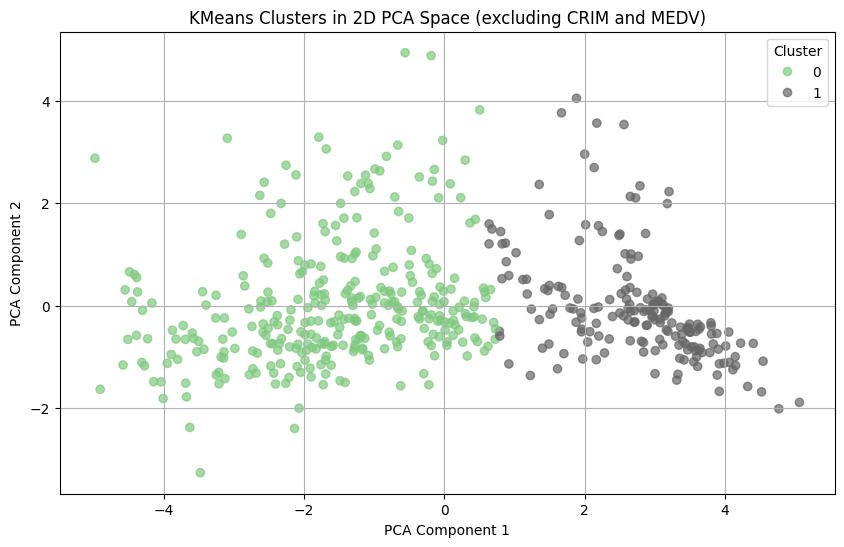

In [48]:
# 1. Select features (exclude CRIM and MEDV)
features_for_clustering = ['ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 
                           'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']  # All complete now

# 2. Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(df[features_for_clustering])

# 3. Fit KMeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df['CRIM_cluster'] = kmeans.fit_predict(X)

# Create a list to store comparison info for previously missing CRIM rows
crim_comparison = []

# 4. Impute CRIM and track comparison with window mean
for cluster_label in df['CRIM_cluster'].unique():
    # Get indices of missing CRIM values in this cluster BEFORE filling
    missing_indices = df[
        (df['CRIM_cluster'] == cluster_label) & (df['CRIM'].isna())
    ].index

    # Compute cluster median from CRIM values that are not missing
    cluster_median = df.loc[
        (df['CRIM_cluster'] == cluster_label) & (df['CRIM'].notna()), 'CRIM'
    ].median()

    for idx in missing_indices:
        # Impute using cluster median
        df.at[idx, 'CRIM'] = cluster_median

        # Compute rolling window mean (excluding current row)
        window_range = range(max(0, idx - 2), min(len(df), idx + 3))
        window_vals = df.loc[list(window_range), 'CRIM']
        window_vals = window_vals.drop(idx)

        if not window_vals.empty:
            window_mean = window_vals.mean()
            diff = abs(cluster_median - window_mean)

            crim_comparison.append({
                'Index': idx,
                'CRIM_cluster_imputed': cluster_median,
                'CRIM_window_mean': window_mean,
                'Difference': diff
            })

# 5. Convert comparison results to DataFrame
crim_comparison_df = pd.DataFrame(crim_comparison)

# 6. Visualize clusters in 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['CRIM_cluster'], cmap='Accent', alpha=0.7)
plt.title("KMeans Clusters in 2D PCA Space (excluding CRIM and MEDV)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True)
plt.show()

In [49]:
# Adopted cluster-wise median imputation for CRIM based on feature similarity using KMeans clustering.
# As a lightweight secondary validation, we compared the imputed values against a rolling window mean 
# (±2 rows) based on row index. While the window mean is simpler and purely local, it tends to fluctuate 
# more, especially in high-CRIM regions with sharp spikes. The comparison confirmed that cluster median 
# imputations are generally more stable and better aligned with feature-based groupings.
crim_comparison_df

,Index,CRIM_cluster_imputed,CRIM_window_mean,Difference
0,53,0.11329,0.030920,0.082370
1,115,0.11329,0.161748,0.048458
2,183,0.11329,0.075865,0.037425
3,191,0.11329,0.065417,0.047873
4,192,0.11329,0.060057,0.053233
5,196,0.11329,0.028135,0.085155
6,229,0.11329,0.427633,0.314343
7,236,0.11329,0.343158,0.229868
8,241,0.11329,0.109070,0.004220
9,262,0.11329,0.612390,0.499100


""
